In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

In [2]:
df = pd.read_csv('/content/rating.csv')
df.head()

<ipython-input-2-d932dbc08167>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/rating.csv')


,userId,movieId,rating,timestamp
0,1.0,2.0,3.5,02-04-2005 23:53
1,1.0,29.0,3.5,02-04-2005 23:31
2,1.0,32.0,3.5,02-04-2005 23:33
3,1.0,47.0,3.5,02-04-2005 23:32
4,1.0,50.0,3.5,02-04-2005 23:29


In [3]:
df.isnull().sum()

userId       343606
movieId      343606
rating       343606
timestamp    343606
dtype: int64

In [4]:
df.shape

(1048575, 4)

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704969 entries, 0 to 704968
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     704969 non-null  float64
 1   movieId    704969 non-null  float64
 2   rating     704969 non-null  float64
 3   timestamp  704969 non-null  object 
dtypes: float64(3), object(1)
memory usage: 26.9+ MB


<Axes: xlabel='rating', ylabel='count'>

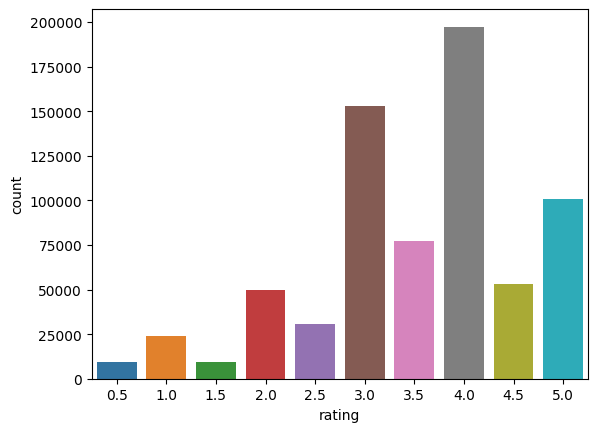

In [11]:
sns.countplot(x='rating', data=df)

In [12]:
# Creating the user-item matrix
user_item_matrix = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [15]:
user_item_matrix

movieId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,129233.0,129303.0,129354.0,129428.0,129707.0,130052.0,130073.0,130219.0,130490.0,130642.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4673.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4674.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4675.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# SVD Model
def svd_collaborative_filtering(ratings_matrix, k=50):
    u, sigma, vt = svds(ratings_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(u, sigma), vt)
    return predicted_ratings

In [17]:
# Neural Collaborative Filtering (NCF) Model
def create_ncf_model(num_users, num_items, embedding_size=20):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
    item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    concat = Concatenate()([user_flatten, item_flatten])
    dense = Dense(128, activation='relu')(concat)
    output = Dense(1, activation='linear')(dense)
    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [18]:
# Evaluation Metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [19]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [20]:
# Precision@K (example for K=10)
def precision_at_k(y_true, y_pred, k=10):
    top_k_items = np.argsort(y_pred)[::-1][:k]
    hits = np.isin(top_k_items, y_true).sum()
    return hits / k

In [48]:
# Data Preparation for NCF
# Convert the user and item IDs to categorical indices
user_ids = df['userId'].astype("category").cat.codes.values
item_ids = df['movieId'].astype("category").cat.codes.values
ratings = df['rating'].values

In [49]:
# Data Preparation for NCF
from sklearn.preprocessing import LabelEncoder

# Create label encoders for user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit and transform the user and item IDs to integer labels
user_ids = user_encoder.fit_transform(df['userId'])
item_ids = item_encoder.fit_transform(df['movieId'])
ratings = df['rating'].values

In [50]:
# Splitting Data for Training and Testing
X = np.column_stack((user_ids, item_ids))
y = ratings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
num_users, num_items = len(df['userId'].unique()), len(df['movieId'].unique())

In [52]:
# Initialize and Train NCF Model
ncf_model = create_ncf_model(num_users, num_items)
ncf_model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=3, batch_size=128, verbose=1)

Epoch 1/3
4407/4407 [==============================] - 32s 7ms/step - loss: 0.9748
Epoch 2/3
4407/4407 [==============================] - 30s 7ms/step - loss: 0.7254
Epoch 3/3
4407/4407 [==============================] - 29s 7ms/step - loss: 0.6962


In [53]:
# Predictions from NCF
y_pred_ncf = ncf_model.predict([X_test[:, 0], X_test[:, 1]]).flatten()

4407/4407 [==============================] - 8s 2ms/step


In [54]:
y_pred_ncf

array([3.8905895, 3.847178 , 4.493211 , ..., 4.234944 , 3.6148746,
       3.839507 ], dtype=float32)

In [55]:
# Evaluate NCF Model
ncf_rmse = rmse(y_test, y_pred_ncf)
ncf_mae = mae(y_test, y_pred_ncf)

In [56]:
(ncf_rmse,ncf_mae)

(0.8463314103849598, 0.6527569526156369)

In [57]:
# Using SVD Model
predicted_ratings_svd = svd_collaborative_filtering(user_item_matrix.values)
actual_ratings = user_item_matrix.values[user_item_matrix.notna()]

In [32]:
# Flatten the matrices for comparison
predicted_ratings_svd_flat = predicted_ratings_svd.flatten()[user_item_matrix.notna().values.flatten()]
actual_ratings_flat = actual_ratings.flatten()

In [33]:
# Evaluate SVD Model
svd_rmse = rmse(actual_ratings_flat, predicted_ratings_svd_flat)
svd_mae = mae(actual_ratings_flat, predicted_ratings_svd_flat)

In [34]:
(svd_rmse, svd_mae)

(0.2882976970721812, 0.06955126239757953)

In [38]:

# Print Evaluation Results
print("SVD RMSE:", svd_rmse)
print("SVD MAE:", svd_mae)
print("\n##############################################\n")
print("NCF RMSE:", ncf_rmse)
print("NCF MAE:", ncf_mae)


SVD RMSE: 0.2882976970721812
SVD MAE: 0.06955126239757953

##############################################

NCF RMSE: 0.8449232236471769
NCF MAE: 0.6443046564576461


## with textual data- NCF

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2

# Example DataFrame
df = pd.DataFrame({
    'userId': np.random.randint(1, 100, 1000),
    'movieId': np.random.randint(1, 500, 1000),
    'rating': np.random.randint(1, 6, 1000),
    'product_description': np.random.choice(['Action', 'Drama', 'Comedy', 'Thriller'], 1000)
})

# Preprocessing Text Data
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['product_description']).toarray()

# Data Preparation for NCF
user_ids = df['userId'].astype("category").cat.codes.values
item_ids = df['movieId'].astype("category").cat.codes.values
ratings = df['rating'].values

X = np.column_stack((user_ids, item_ids, tfidf_matrix))
y = ratings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_users, num_items = len(df['userId'].unique()), len(df['movieId'].unique())

# NCF Model with Text Feature
def create_ncf_model_with_text(num_users, num_items, text_features_dim, embedding_size=20):
    # User, Item, and Text Input Layers
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    text_input = Input(shape=(text_features_dim,))

    # Embeddings
    user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
    item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)

    # Flatten the embeddings
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)

    # Concatenate all inputs
    concat = Concatenate()([user_flatten, item_flatten, text_input])

    # Neural network layers
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concat)
    dropout = Dropout(0.5)(dense)
    output = Dense(1, activation='linear')(dropout)

    model = Model(inputs=[user_input, item_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and Train the Model
ncf_model = create_ncf_model_with_text(num_users, num_items, tfidf_matrix.shape[1])
ncf_model.fit([X_train[:, 0], X_train[:, 1], X_train[:, 2:]], y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the Model
y_pred_ncf = ncf_model.predict([X_test[:, 0], X_test[:, 1], X_test[:, 2:]]).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ncf))

print("NCF Model with Text Feature RMSE:", rmse)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704969 entries, 0 to 704968
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     704969 non-null  float64
 1   movieId    704969 non-null  float64
 2   rating     704969 non-null  float64
 3   timestamp  704969 non-null  object 
dtypes: float64(3), object(1)
memory usage: 26.9+ MB


In [66]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Load the dataset with specified data type for the column
df = pd.read_csv('/content/rating.csv', dtype={3: str})

#df = df[['userId','movieId', 'rating']]

# Data Preprocessing
df = df.dropna()  # Drop missing values
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()

# User-item matrix for SVD
user_item_matrix = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert user and item IDs to categorical codes for NCF
from sklearn.preprocessing import LabelEncoder

# Create label encoders for user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit and transform the user and item IDs to integer labels
user_ids = user_encoder.fit_transform(df['userId'])
item_ids = item_encoder.fit_transform(df['movieId'])
ratings = df['rating'].values

X = np.column_stack((user_ids, item_ids))
y = ratings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVD Model
def svd_collaborative_filtering(ratings_matrix, k=50):
    u, sigma, vt = svds(ratings_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(u, sigma), vt)
    return predicted_ratings

# Neural Collaborative Filtering (NCF) Model with Enhanced Layers
def create_ncf_model(num_users, num_items, embedding_size=20):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
    item_embedding = Embedding(num_items, embedding_size, input_length=1)(item_input)
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    concat = Concatenate()([user_flatten, item_flatten])
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concat)
    dropout1 = Dropout(0.05)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.03)(dense2)
    output = Dense(1, activation='linear')(dropout2)
    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Early Stopping and Learning Rate Scheduler for NCF
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 2 else lr)

# Training the NCF Model
# Split user IDs and item IDs in training and testing sets
X_train_users, X_train_items = X_train[:, 0], X_train[:, 1]
X_test_users, X_test_items = X_test[:, 0], X_test[:, 1]

# Convert to tf.data.Dataset and structure for two inputs
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_users, X_train_items), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_users, X_test_items), y_test))

# Apply shuffle and batch
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128)
test_dataset = test_dataset.batch(128)

# Training the NCF Model
ncf_model = create_ncf_model(num_users, num_items)
ncf_model.fit(train_dataset, epochs=5, callbacks=[early_stopping, lr_scheduler])

# Predictions and Evaluation for NCF Model
y_pred_ncf = ncf_model.predict(test_dataset).flatten()
ncf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ncf))
ncf_mae = mean_absolute_error(y_test, y_pred_ncf)


# Using SVD Model
predicted_ratings_svd = svd_collaborative_filtering(user_item_matrix.values)
actual_ratings = user_item_matrix.values[user_item_matrix.notna()]

# Flatten the matrices for comparison
predicted_ratings_svd_flat = predicted_ratings_svd.flatten()[user_item_matrix.notna().values.flatten()]
actual_ratings_flat = actual_ratings.flatten()

# Evaluate SVD Model
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

svd_rmse = rmse(actual_ratings_flat, predicted_ratings_svd_flat)
svd_mae = mae(actual_ratings_flat, predicted_ratings_svd_flat)

# Print Evaluation Results
print("SVD RMSE:", svd_rmse)
print("SVD MAE:", svd_mae)
print("\n##############################################\n")
print("NCF RMSE:", ncf_rmse)
print("NCF MAE:", ncf_mae)

Epoch 1/5
4401/4407 [============================>.] - ETA: 0s - loss: 0.9258

4407/4407 [==============================] - 38s 8ms/step - loss: 0.9257 - lr: 0.0010
Epoch 2/5
4405/4407 [============================>.] - ETA: 0s - loss: 0.7532

4407/4407 [==============================] - 37s 8ms/step - loss: 0.7531 - lr: 0.0010
Epoch 3/5
4406/4407 [============================>.] - ETA: 0s - loss: 0.7064

4407/4407 [==============================] - 36s 8ms/step - loss: 0.7065 - lr: 0.0010
Epoch 4/5
4405/4407 [============================>.] - ETA: 0s - loss: 0.6625

4407/4407 [==============================] - 36s 8ms/step - loss: 0.6626 - lr: 9.0000e-04
Epoch 5/5
4407/4407 [==============================] - ETA: 0s - loss: 0.6308

1102/1102 [==============================] - 2s 2ms/step
SVD RMSE: 0.2882976970721813
SVD MAE: 0.06955126239757954

##############################################

NCF RMSE: 0.8759149244755248
NCF MAE: 0.6740387127726887


In [ ]:
\